# Investigating the NIPS Sparse Dataset on FROSTT

In this notebook we inspect data from the [NIPS](http://frostt.io/tensors/nips/) dataset from the [FROSTT sparse tensor repository](http://frostt.io).

The dataset includes a 4-mode (4-dimensions) sparse tensor of all papers published from NIPS between 1987 and 2003. The axis are:

- Papers
- Authors
- Words (stopwords filtered out)
- Years

The values in the tensor indicate wordcount at each `(paper, author, word, year)` index.

## Load the Data

Datsets on on `FROSTT` are stored in a custom format, we'll download and parse them here. The sparse tensor is stored in one file, and axis information for each mode is stored in additional individual files.

In [1]:
import gzip
import os
from urllib.request import urlretrieve
import numpy as np
import sparse
import pandas as pd
%matplotlib inline

def download_files():
    "Download the file if they don't already exist."
    for filename in ['nips.tns.gz',
                     'mode-1-papers.map.gz',
                     'mode-2-authors.map.gz',
                     'mode-3-words.map.gz',
                     'mode-4-years.map.gz']:
        url = 'https://s3.us-east-2.amazonaws.com/frostt/frostt_data/nips/' + filename
        if not os.path.exists(filename):
            urlretrieve(url, filename)

            
def load_data(path):
    """Load the sparse tensor dataset at `path`"""
    values = []
    coords = []
    with gzip.open(path, 'rb') as f:
        for line in f:
            data = line.strip().split(b' ')
            coords.append([int(i) - 1 for i in data[:-1]])
            values.append(float(data[-1]))
    coords = np.array(coords, dtype=np.int32).T
    values = np.array(values, dtype=np.float64)
    return sparse.COO(coords, data=values)


def load_mode(path):
    """Load the axis information for the mode file at `path`"""
    with gzip.open(path, 'rt') as f:
        return pd.Series(f.read().splitlines())

In [2]:
download_files()

tensor = load_data('nips.tns.gz')
papers = load_mode('mode-1-papers.map.gz')
authors = load_mode('mode-2-authors.map.gz')
words = load_mode('mode-3-words.map.gz')
years = load_mode('mode-4-years.map.gz')

## Inspect the Data

After loading the data, we should inspect the dataset before performing any analysis.

In [3]:
tensor

<COO: shape=(2482, 2862, 14036, 17), dtype=float64, nnz=3101609, fill_value=0.0>

The tensor was loaded as an instance of `sparse.COO`, from the [sparse](http://sparse.pydata.org/en/latest/) library. This library supports n-dimensional sparse arrays in python, with a `numpy`-like interface.

To get the *actual* memory used by the sparse array, we can look at the `nbytes` attribute:

In [4]:
tensor.nbytes / 1e9                # Actual memory usage in GB

0.12406436

If this was a dense array, the data would take a much larger amount of memory. We can calculate this as:

In [5]:
np.prod(tensor.shape) * 8 / 1e9    # Memory usage if array was dense, in GB

13559.812193664

Looking at the density of the array (fraction of elements that are non-zero):

In [6]:
print('Sparse array has %d non-zero elements, with a density of %.2e'
      % (tensor.nnz, tensor.density))

Sparse array has 3101609 non-zero elements, with a density of 1.83e-06


We can inspect the dimensionality of the tensor:

In [7]:
tensor.shape

(2482, 2862, 14036, 17)

Like `numpy` arrays, `sparse` arrays support many of the common methods:

In [8]:
# The most frequently a word has been used in a single paper
tensor.max()

160.0

In [9]:
# The average number of times a word is used in a single paper
tensor.mean()

4.597517363045033e-06

### Total word-count per author

We can compute the total number of words-per-author over the whole dataset by summing along 3 of the 4 axis. Here we determine the wordiest authors, and make a plot of word count per author for the whole dataset.

In [10]:
total_words = pd.Series(tensor.sum(axis=(0, 2, 3)).todense(),
                        name='total_words',
                        index=authors)

In [11]:
total_words.nlargest().to_frame()

,total_words
Sejnowski_T,67793.0
Jordan_M,60068.0
Hinton_G,48792.0
Dayan_P,41006.0
Koch_C,39737.0


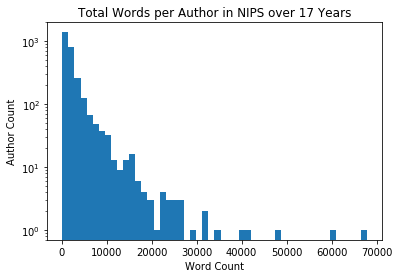

In [12]:
(total_words
 .plot.hist(bins=50, title='Total Words per Author in NIPS over 17 Years', logy=True)
 .set(xlabel='Word Count', ylabel='Author Count'));

### Total word-count per word

We can compute the frequency  over the whole dataset by summing along 3 of the 4 axis. Here we determine the frequency of each word in the whole dataset, and make a plot of word frequency.

In [13]:
word_frequencies = pd.Series(tensor.sum(axis=(0, 1, 3)).todense(),
                             name='word_frequencies',
                             index=words)

In [14]:
word_frequencies.nsmallest().to_frame()

,word_frequencies
diagonally,7.0
ack,8.0
ale,8.0
colliding,8.0
delivering,8.0


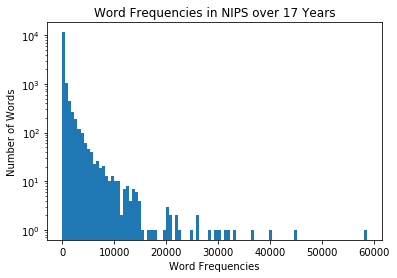

In [15]:
(word_frequencies
 .plot.hist(bins=100, title='Word Frequencies in NIPS over 17 Years', logy=True)
 .set(xlabel='Word Frequencies', ylabel='Number of Words'));

## Using tensorly to operate on generic tensors

[Tensorly](https://github.com/tensorly/tensorly) is a library for doing tensor learning in Python. It supports several backends with a uniform interface:

- `numpy`
- `pytorch`
- `mxnet`
- `tensorflow`
- `cupy`

To ensure algorithms run on every backend, it abstracts out the necessary operations for each backend, and uses those exclusively instead of methods on the tensors themselves.

For example, instead of calling

`tensor.shape`

you'd use

`tensorly.shape(tensor)`

To change backends, use the `tensorly.set_backend` function, and use the `tensorly.get_backend` function to see the current backend.

In [16]:
import tensorly as tl

In [17]:
tl.get_backend()

'numpy'

We've added `sparse` tensor support in the namespace `tensorly.contrib.sparse`. The intent is that there will be equivalent sparse functionality for all of the existing backends, and the `tensorly.contrib.sparse` namespace will mirror the normal `tensorly` namespace, with operations specialized for sparse tensors. For now, sparse functionality is only implemented for the `numpy` backend.

In [18]:
import tensorly.contrib.sparse as tlsp

To see all the methods that are the same between the namespaces:

In [19]:
sorted(i for i in set(dir(tl)).intersection(dir(tlsp))
       if not i.startswith('_'))

['SVD_FUNS',
 'abs',
 'all',
 'arange',
 'backend',
 'clip',
 'concatenate',
 'context',
 'copy',
 'dot',
 'eye',
 'float32',
 'float64',
 'fold',
 'get_backend',
 'int32',
 'int64',
 'is_tensor',
 'kr',
 'kron',
 'kruskal_to_tensor',
 'kruskal_to_unfolded',
 'kruskal_to_vec',
 'max',
 'mean',
 'min',
 'moveaxis',
 'mps_to_tensor',
 'mps_to_unfolded',
 'mps_to_vec',
 'ndim',
 'norm',
 'ones',
 'partial_fold',
 'partial_svd',
 'partial_tensor_to_vec',
 'partial_unfold',
 'partial_vec_to_tensor',
 'prod',
 'qr',
 'reshape',
 'set_backend',
 'shape',
 'sign',
 'solve',
 'sqrt',
 'sum',
 'tensor',
 'tensor_to_vec',
 'to_numpy',
 'transpose',
 'tucker_to_tensor',
 'tucker_to_unfolded',
 'tucker_to_vec',
 'unfold',
 'vec_to_tensor',
 'where',
 'zeros',
 'zeros_like']

Demonstrating a few of the generic backend functions:

In [20]:
# Get the shape of a tensor
tlsp.shape(tensor)

(2482, 2862, 14036, 17)

In [21]:
# Take the mean of a tensor
tlsp.mean(tensor)

4.597517363045033e-06

In [22]:
# Take the sum of a tensor
tlsp.sum(tensor)

7792684.0

## Partial Tucker Decomposition

Here we demonstrate computing a partial tucker decomposition along 2 of the modes:

- `authors`
- `words`

each with an output rank of 5. To do this, we import the `partial_tucker` function from the `tensorly.contrib.sparse.decomposition` module. Note that this mirrors the functionality for dense tensors in `tensorly.decomposition`.

To profile our computation, we'll time it, as well as determine the peak memory usage using the [`memory_profiler`](https://github.com/pythonprofilers/memory_profiler) notebook extension.

In [23]:
from tensorly.contrib.sparse.decomposition import partial_tucker

In [24]:
import time
%load_ext memory_profiler

In [25]:
%%memit
start_time = time.time()
core, factors = partial_tucker(tensor,
                               modes=[1, 2],
                               rank=[5, 5],
                               init='random',
                               verbose=True,
                               tol=1e-3)
end_time = time.time()
total_time = end_time - start_time
print('Took %d mins %d secs' % (divmod(total_time, 60)))

reconsturction error=0.993453469191386, variation=4.833597356423969e-05.
converged in 2 iterations.
Took 3 mins 52 secs
peak memory: 9411.13 MiB, increment: 8950.79 MiB


The peak memory usage was much lower than the size of the dense tensor, showing that the sparse tensor was never fully converted to a dense representation in memory.

Looking at the output results, we can have two objects:

- `core`: the core tensor from the decomposition. This is a sparse result.
- `factors`: a list of factor arrays for each mode. These are dense.

In [26]:
core

<COO: shape=(2482, 5, 5, 17), dtype=float64, nnz=62050, fill_value=0.0>

In [27]:
author_factor, word_factor = factors

Looking at a single factor array, we can see that it's a numpy array, with dtype `float64`, and a shape of `(axis_length, rank)`:

In [28]:
type(author_factor)

numpy.ndarray

In [29]:
author_factor.dtype

dtype('float64')

In [30]:
author_factor.shape

(2862, 5)

We can plot these factors as heatmaps, to better view their representation.

In [31]:
import matplotlib.pyplot as plt
from matplotlib import colors

def plot_factors(x, thresh=0.005):
    """Plot the factors on a logarithmic z scale, clipping points
    with an absolute value less than `thresh` to 0."""
    ax = plt.pcolormesh(np.where(np.abs(x) < thresh, np.nan, x),
                        cmap='coolwarm',
                        norm=colors.SymLogNorm(linthresh=thresh,
                                               linscale=thresh,
                                               vmin=x.min(),
                                               vmax=x.max()))
    return ax

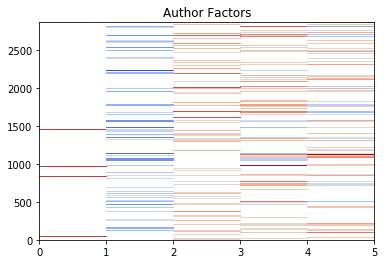

In [32]:
fig = plot_factors(author_factor)
plt.title('Author Factors');

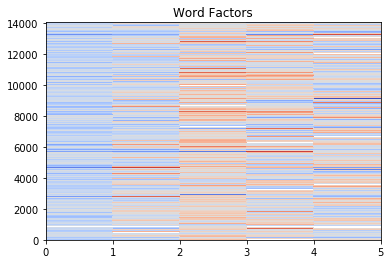

In [33]:
fig = plot_factors(word_factor)
plt.title('Word Factors');

This functionality is not yet merged into `tensorly`, but should be in the coming weeks. The relevant PRs can be viewed at:

- [#76](https://github.com/tensorly/tensorly/pull/76): Refactor tensorly backend support
- [#77](https://github.com/tensorly/tensorly/pull/77): At sparse tensor support to tensorly